In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.functions import emission_profile_function
from metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from climate_models.co2_ipcc_climate_model import co2_ipcc_climate_model
from climate_models.gwpstar_climate_model import species_gwpstar_climate_model
from climate_models.lwe_climate_model import species_lwe_climate_model
from climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model

## Parameters

In [2]:
climate_model = "FaIR" # "GWP*", "LWE, "FaIR"
co2_method = 'FaIR' # IPCC or FaIR

if climate_model == "FaIR":
    start_year = 1765
else:
    start_year = 2000
t0 = 2020

if climate_model == "GWP*" or climate_model == "LWE":
    tcre = 0.00045

settings = "Lee" # "Lee", "Bickel"

## Metrics calculation

In [3]:
j = 0
time_horizon_range = range(20,110,10)
gwp_rf = np.zeros((len(time_horizon_range),6))
gwp_erf = np.zeros((len(time_horizon_range),6))
egwp_rf = np.zeros((len(time_horizon_range),6))
egwp_erf = np.zeros((len(time_horizon_range),6))
gtp = np.zeros((len(time_horizon_range),6))
ratr = np.zeros((len(time_horizon_range),6))

sensitivity_erf_co2 = 9.2e-16 # Not used with FaIR
ratio_erf_rf_co2 = 1
efficacy_erf_co2 = 1
unit_value_co2 = 1*10**10

for species in ["Aviation contrails", "Aviation NOx - ST O3 increase", "Aviation NOx - CH4 decrease and induced", "Aviation H2O", "Aviation soot", "Aviation sulfur"]:
    
    if species == "Aviation contrails":
        unit_value = 1*10**10
        sensitivity_erf = 9.36e-13
        if settings == "Lee":
            ratio_erf_rf = 0.42
            efficacy_erf = 1
        elif settings == "Bickel":
            ratio_erf_rf = 0.55
            efficacy_erf = 0.38
    elif species == "Aviation NOx - ST O3 increase":
        unit_value = 1*10**10
        sensitivity_erf = 34.4e-12 * (14/46)
        ratio_erf_rf = 1.37
        efficacy_erf = 1
    elif species == "Aviation NOx - CH4 decrease and induced":
        unit_value = 1*10**10
        sensitivity_erf = -0.695e-9
        ratio_erf_rf = 1.18
        efficacy_erf = 1
    elif species == "Aviation H2O":
        unit_value = 1*10**12
        sensitivity_erf = 0.0052e-12
        ratio_erf_rf = 1
        efficacy_erf = 1
    elif species == "Aviation soot":
        unit_value = 1*10**14
        sensitivity_erf = 100.7e-12 # Not used
        ratio_erf_rf = 1
        efficacy_erf = 1
    elif species == "Aviation sulfur":
        unit_value = 1*10**10
        sensitivity_erf = -19.9e-12 # Not used
        ratio_erf_rf = 1
        efficacy_erf = 1
    
    unit_value_co2 = 1*10**10
    
    k = 0
    for time_horizon in time_horizon_range:
        end_year = t0 + time_horizon
        if climate_model == "FaIR" or co2_method == "FaIR":
            background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')
        
        emission_profile_co2 = emission_profile_function(start_year,t0,time_horizon, 'pulse', unit_value_co2)
        emission_profile = emission_profile_function(start_year,t0,time_horizon, 'pulse', unit_value)
        
        if co2_method == 'IPCC':
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = co2_ipcc_pulse_absolute_metrics(time_horizon)
        elif co2_method == 'FaIR':
            species_settings_co2 = {"sensitivity_erf": sensitivity_erf_co2, "ratio_erf_rf": ratio_erf_rf_co2, "efficacy_erf": efficacy_erf_co2}
            model_settings_co2 = {"background_species_quantities": background_species_quantities}
            radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2 = species_fair_climate_model(start_year, end_year, "Aviation CO2", emission_profile_co2, species_settings_co2, model_settings_co2)
            radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, temperature_co2_unit = radiative_forcing_co2/unit_value_co2, effective_radiative_forcing_co2/unit_value_co2, temperature_co2/unit_value_co2
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = absolute_metrics(radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, efficacy_erf_co2, temperature_co2_unit, time_horizon)
        if climate_model == "GWP*":
            species_settings = {"sensitivity_erf": sensitivity_erf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
            model_settings = {"tcre": tcre}
            radiative_forcing, effective_radiative_forcing, temperature = species_gwpstar_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
        elif climate_model == "LWE":
            species_settings = {"sensitivity_erf": sensitivity_erf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
            model_settings = {"tcre": tcre}
            radiative_forcing, effective_radiative_forcing, temperature = species_lwe_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
        elif climate_model == "FaIR":
            species_settings = {"sensitivity_erf": sensitivity_erf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
            model_settings = {"background_species_quantities": background_species_quantities}
            radiative_forcing, effective_radiative_forcing, temperature = species_fair_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
        radiative_forcing_unit, effective_radiative_forcing_unit, temperature_unit = radiative_forcing/unit_value, effective_radiative_forcing/unit_value, temperature/unit_value
        agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = absolute_metrics(radiative_forcing_unit, effective_radiative_forcing_unit, efficacy_erf, temperature_unit, time_horizon)
        
        gwp_rf[k,j], gwp_erf[k,j], egwp_rf[k,j], egwp_erf[k,j], gtp[k,j], igtp, ratr[k,j] = relative_metrics(agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2, agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr)
        
        k += 1
        
    j += 1

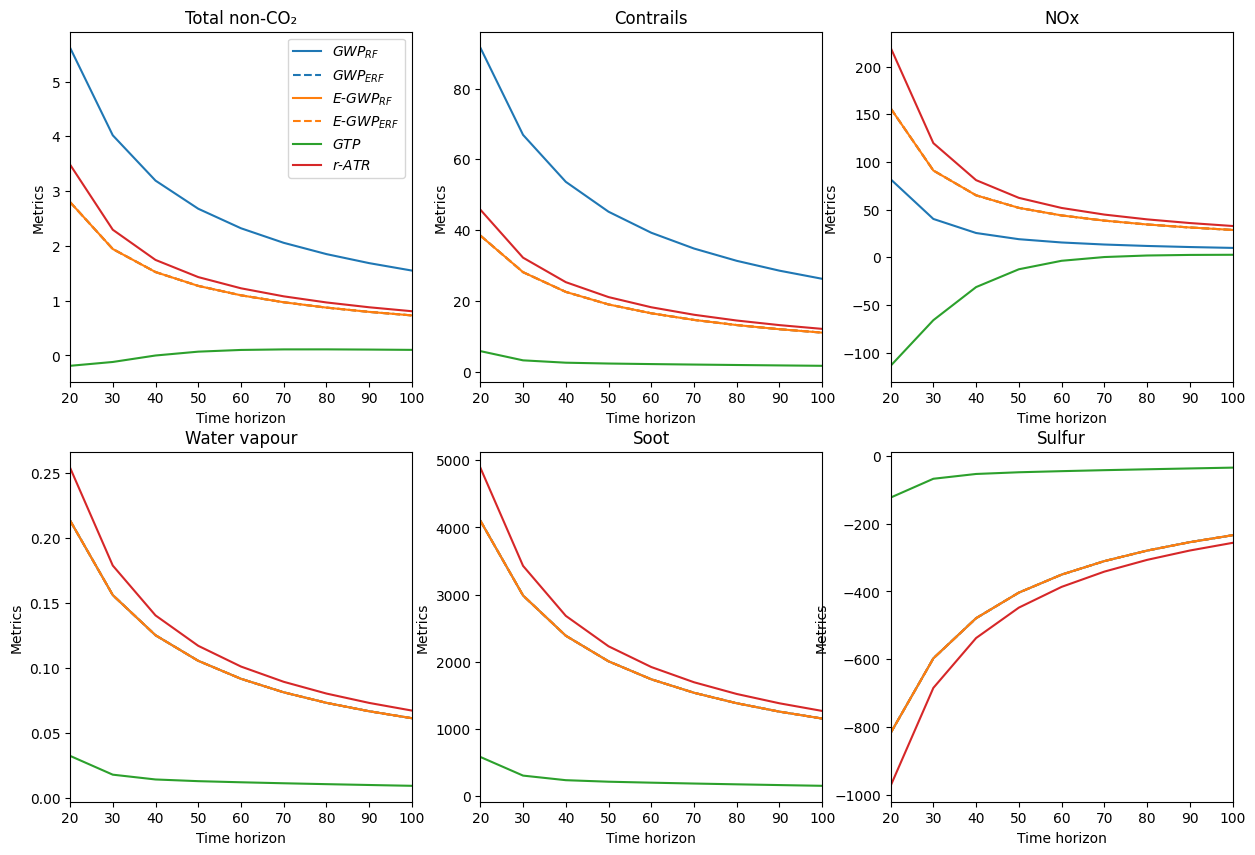

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
k = 0

# Ratio based on 2018 data
ratio_contrails = 61.3/1033.7 # Million km / MtCO2
ratio_nox = 1.4*46/14/1033.7 # MtNOx / MtCO2
ratio_h2o = 382.55/1033.7 # MtH2O / MtCO2
ratio_soot = 0.0093/1033.7 # MtBC / MtCO2
ratio_sulfur = 0.37/1033.7 # MtSOx / MtCO2

for i, ax in enumerate(axes.flat):
    if i == 0:
        x_axis = time_horizon_range
        ax.plot(x_axis, ratio_contrails*gwp_rf[:, i+0]+ratio_nox*(gwp_rf[:, i+2]+gwp_rf[:, i+1])+ratio_h2o*gwp_rf[:, i+3]+ratio_soot*gwp_rf[:, i+4]+ratio_sulfur*gwp_rf[:, i+5], label=r'$GWP_{RF}$', color='C0')
        ax.plot(x_axis, ratio_contrails*gwp_erf[:, i+0]+ratio_nox*(gwp_erf[:, i+2]+gwp_erf[:, i+1])+ratio_h2o*gwp_erf[:, i+3]+ratio_soot*gwp_erf[:, i+4]+ratio_sulfur*gwp_erf[:, i+5], label=r'$GWP_{ERF}$', color='C0', linestyle='--')
        ax.plot(x_axis, ratio_contrails*egwp_rf[:, i+0]+ratio_nox*(egwp_rf[:, i+2]+egwp_rf[:, i+1])+ratio_h2o*egwp_rf[:, i+3]+ratio_soot*egwp_rf[:, i+4]+ratio_sulfur*egwp_rf[:, i+5], label=r'$E\text{-}GWP_{RF}$', color='C1')
        ax.plot(x_axis, ratio_contrails*egwp_erf[:, i+0]+ratio_nox*(egwp_erf[:, i+2]+egwp_erf[:, i+1])+ratio_h2o*egwp_erf[:, i+3]+ratio_soot*egwp_erf[:, i+4]+ratio_sulfur*egwp_erf[:, i+5], label=r'$E\text{-}GWP_{ERF}$', color='C1', linestyle='--')
        ax.plot(x_axis, ratio_contrails*gtp[:, i+0]+ratio_nox*(gtp[:, i+2]+gtp[:, i+1])+ratio_h2o*gtp[:, i+3]+ratio_soot*gtp[:, i+4]+ratio_sulfur*gtp[:, i+5], label=r'$GTP$', color='C2')
        ax.plot(x_axis, ratio_contrails*ratr[:, i+0]+ratio_nox*(ratr[:, i+2]+ratr[:, i+1])+ratio_h2o*ratr[:, i+3]+ratio_soot*ratr[:, i+4]+ratio_sulfur*ratr[:, i+5], label=r'$r\text{-}ATR$', color='C3')
        ax.legend()
    elif i == 1:
        ax.plot(x_axis, gwp_rf[:, i-1], label=r'$GWP_{RF}$', color='C0')
        ax.plot(x_axis, gwp_erf[:, i-1], label=r'$GWP_{ERF}$', color='C0', linestyle='--')
        ax.plot(x_axis, egwp_rf[:, i-1], label=r'$E\text{-}GWP_{RF}$', color='C1')
        ax.plot(x_axis, egwp_erf[:, i-1], label=r'$E\text{-}GWP_{ERF}$', color='C1', linestyle='--')
        ax.plot(x_axis, gtp[:, i-1], label=r'$GTP$', color='C2')
        ax.plot(x_axis, ratr[:, i-1], label=r'$r\text{-}ATR$', color='C3')
    elif i == 2:
        ax.plot(x_axis, gwp_rf[:, i-1]+gwp_rf[:, i], label=r'$GWP_{RF}$', color='C0')
        ax.plot(x_axis, gwp_erf[:, i-1]+gwp_erf[:, i], label=r'$GWP_{ERF}$', color='C0', linestyle='--')
        ax.plot(x_axis, egwp_rf[:, i-1]+egwp_rf[:, i], label=r'$E\text{-}GWP_{RF}$', color='C1')
        ax.plot(x_axis, egwp_erf[:, i-1]+egwp_erf[:, i], label=r'$E\text{-}GWP_{ERF}$', color='C1', linestyle='--')
        ax.plot(x_axis, gtp[:, i-1]+gtp[:, i], label=r'$GTP$', color='C2')
        ax.plot(x_axis, ratr[:, i-1]+ratr[:, i], label=r'$r\text{-}ATR$', color='C3')
    else:
        x_axis = time_horizon_range
        ax.plot(x_axis, gwp_rf[:, i], label=r'$GWP_{RF}$', color='C0')
        ax.plot(x_axis, gwp_erf[:, i], label=r'$GWP_{ERF}$', color='C0', linestyle='--')
        ax.plot(x_axis, egwp_rf[:, i], label=r'$E\text{-}GWP_{RF}$', color='C1')
        ax.plot(x_axis, egwp_erf[:, i], label=r'$E\text{-}GWP_{ERF}$', color='C1', linestyle='--')
        ax.plot(x_axis, gtp[:, i], label=r'$GTP$', color='C2')
        ax.plot(x_axis, ratr[:, i], label=r'$r\text{-}ATR$', color='C3')
    ax.set_xlim(min(time_horizon_range),max(time_horizon_range))
    ax.set_xlabel('Time horizon')
    ax.set_ylabel('Metrics')
    if i == 0:
        ax.set_title('Total non-CO₂')
    elif i == 1:
        ax.set_title('Contrails')
    elif i == 2:
        ax.set_title('NOx')
    elif i == 3:
        ax.set_title('Water vapour')
    elif i == 4:
        ax.set_title('Soot')
    elif i == 5:
        ax.set_title('Sulfur')
    
plt.show()

In [5]:
time_horizon_range = ["20","50","100"]
index_noms = ["GWP_RF", "GWP_ERF", "E-GWP_RF", "E-GWP_ERF", "GTP", "r-ATR"]
for i in range(0,6):
    if i!= 1 and i != 2:
        if i == 0:
            print("Contrails")
        if i == 3:
            print("Water vapour")
        if i == 4:
            print("Soot")
        if i == 5:
            print("Sulfur")
        values = [[gwp_rf[0,i],gwp_rf[3,i],gwp_rf[8,i]],
                           [gwp_erf[0,i],gwp_erf[3,i],gwp_erf[8,i]],
                           [egwp_rf[0,i],egwp_rf[3,i],egwp_rf[8,i]],
                           [egwp_erf[0,i],egwp_erf[3,i],egwp_erf[8,i]],
                           [gtp[0,i],gtp[3,i],gtp[8,i]],
                           [ratr[0,i],ratr[3,i],ratr[8,i]]]
        round_values = [[round(val, 2) for val in row] for row in values]
        df = pd.DataFrame(round_values, columns=pd.Index(time_horizon_range, name="Time horizon"), index=index_noms)
        print(df)
        print("")
    elif i == 1:
        print("NOx")
        values = [[gwp_rf[0,i]+gwp_rf[0,i+1],gwp_rf[3,i]+gwp_rf[3,i+1],gwp_rf[8,i]+gwp_rf[8,i+1]],
                           [gwp_erf[0,i]+gwp_erf[0,i+1],gwp_erf[3,i]+gwp_erf[3,i+1],gwp_erf[8,i]+gwp_erf[8,i+1]],
                           [egwp_rf[0,i]+egwp_rf[0,i+1],egwp_rf[3,i]+egwp_rf[3,i+1],egwp_rf[8,i]+egwp_rf[8,i+1]],
                           [egwp_erf[0,i]+egwp_erf[0,i+1],egwp_erf[3,i]+egwp_erf[3,i+1],egwp_erf[8,i]+egwp_erf[8,i+1]],
                           [gtp[0,i]+gtp[0,i+1],gtp[3,i]+gtp[3,i+1],gtp[8,i]+gtp[8,i+1]],
                           [ratr[0,i]+ratr[0,i+1],ratr[3,i]+ratr[3,i+1],ratr[8,i]+ratr[8,i+1]]]
        round_values = [[round(val, 2) for val in row] for row in values]
        df = pd.DataFrame(round_values, columns=pd.Index(time_horizon_range, name="Time horizon"), index=index_noms)
        print(df)
        print("")
    else:
        pass
        

Contrails
Time horizon     20     50    100
GWP_RF        91.58  45.20  26.23
GWP_ERF       38.47  18.98  11.02
E-GWP_RF      38.47  18.98  11.02
E-GWP_ERF     38.47  18.98  11.02
GTP            5.79   2.28   1.64
r-ATR         45.79  21.07  12.08

NOx
Time horizon      20     50    100
GWP_RF         81.83  18.93   9.79
GWP_ERF       156.23  51.79  28.64
E-GWP_RF      156.23  51.79  28.64
E-GWP_ERF     156.23  51.79  28.64
GTP          -113.89 -12.63   2.58
r-ATR         219.87  62.29  32.78

Water vapour
Time horizon    20    50   100
GWP_RF        0.21  0.11  0.06
GWP_ERF       0.21  0.11  0.06
E-GWP_RF      0.21  0.11  0.06
E-GWP_ERF     0.21  0.11  0.06
GTP           0.03  0.01  0.01
r-ATR         0.25  0.12  0.07

Soot
Time horizon       20       50      100
GWP_RF        4101.32  2005.98  1153.29
GWP_ERF       4101.32  2005.98  1153.29
E-GWP_RF      4101.32  2005.98  1153.29
E-GWP_ERF     4101.32  2005.98  1153.29
GTP            581.55   212.75   151.62
r-ATR         4890.69  22